# **Beijing Air Quality Forecasting Notebook**

In [48]:
# Google Drive mounted to access datasets
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [49]:
# Importing libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.layers import Dropout


In [50]:
# Load the datasets
# train.csv and test.csv saved in Google Drive folder.
# Replace the file paths below with the actual paths to your dataset.
train = pd.read_csv('/content/drive/MyDrive/Kaggle_competition_ML/air_quality_forcasting/train.csv')
test = pd.read_csv('/content/drive/MyDrive/Kaggle_competition_ML/air_quality_forcasting/test.csv')

# **Explore the training data**
In this sections explore your dataset with appropiate statistics and visualisations to understand your better. Ensure that you explain output of every code cell and what it entails.

In [51]:
# Data set first few rows inspection.
print("Training Data Overview:")
train.head()

Training Data Overview:


,No,DEWP,TEMP,PRES,Iws,Is,Ir,datetime,cbwd_NW,cbwd_SE,cbwd_cv,pm2.5
0,1,-1.580878,-1.922250,0.443328,-0.441894,-0.069353,-0.137667,2010-01-01 00:00:00,1.448138,-0.732019,-0.522096,NaN
1,2,-1.580878,-2.004228,0.345943,-0.379306,-0.069353,-0.137667,2010-01-01 01:00:00,1.448138,-0.732019,-0.522096,NaN
2,3,-1.580878,-1.922250,0.248559,-0.343514,-0.069353,-0.137667,2010-01-01 02:00:00,1.448138,-0.732019,-0.522096,NaN
3,4,-1.580878,-2.168183,0.248559,-0.280926,-0.069353,-0.137667,2010-01-01 03:00:00,1.448138,-0.732019,-0.522096,NaN
4,5,-1.511594,-2.004228,0.151174,-0.218339,-0.069353,-0.137667,2010-01-01 04:00:00,1.448138,-0.732019,-0.522096,NaN


**1. Time Series Trend visualization for PM2.5:**

The plot shows the trend of PM2.5 concentrations over time.
PM2.5 refers to fine particulate matter in the air, which is a key indicator of air quality.

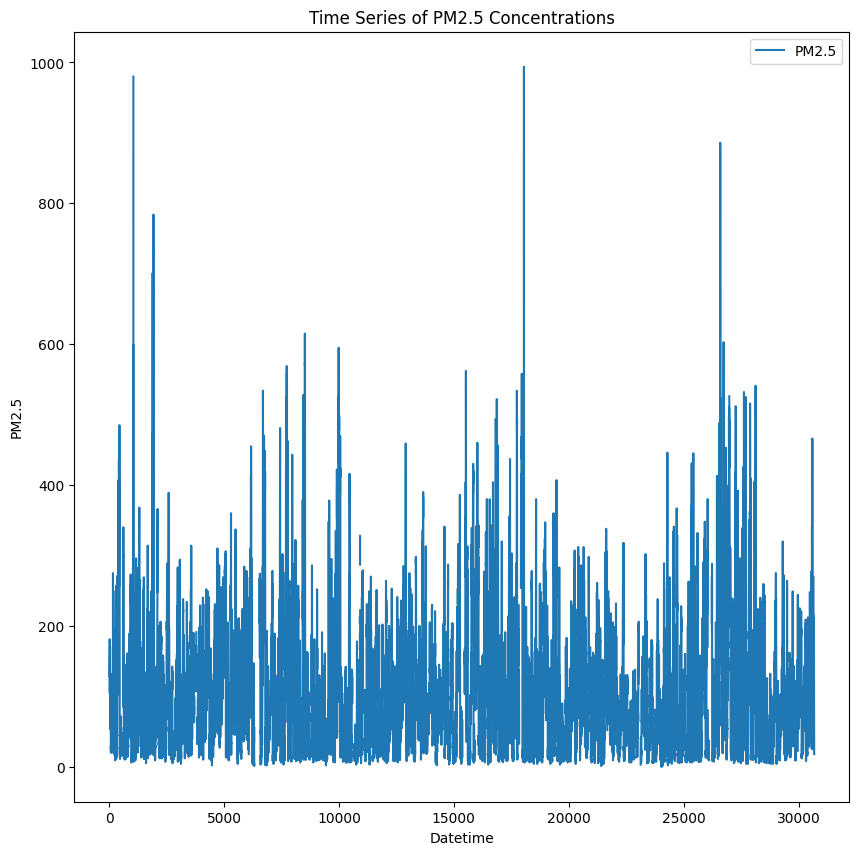

In [52]:
# Visualization
# Time series trend for PM2.5
# datetime information acess from index of DataFrame
plt.figure(figsize=(10, 10))
plt.plot(train.index, train['pm2.5'], label='PM2.5')
plt.title('Time Series of PM2.5 Concentrations')
plt.xlabel('Datetime')
plt.ylabel('PM2.5')
plt.legend()
plt.show()


**Interpretation of the above Result.**

High PM2.5 concentrations (e.g., values close to 1000) indicate poor air quality, which could be due to factors like industrial activity, vehicle emissions, or weather conditions.

If the plot shows consistent spikes at certain times (e.g., winter months), it might suggest seasonal pollution sources, such as heating or reduced air dispersion.

**2. Correlation Matrix of Features:**
The correlation matrix shows the relationships (correlations) between different features in the dataset.


Correlation values range from -1 to 1

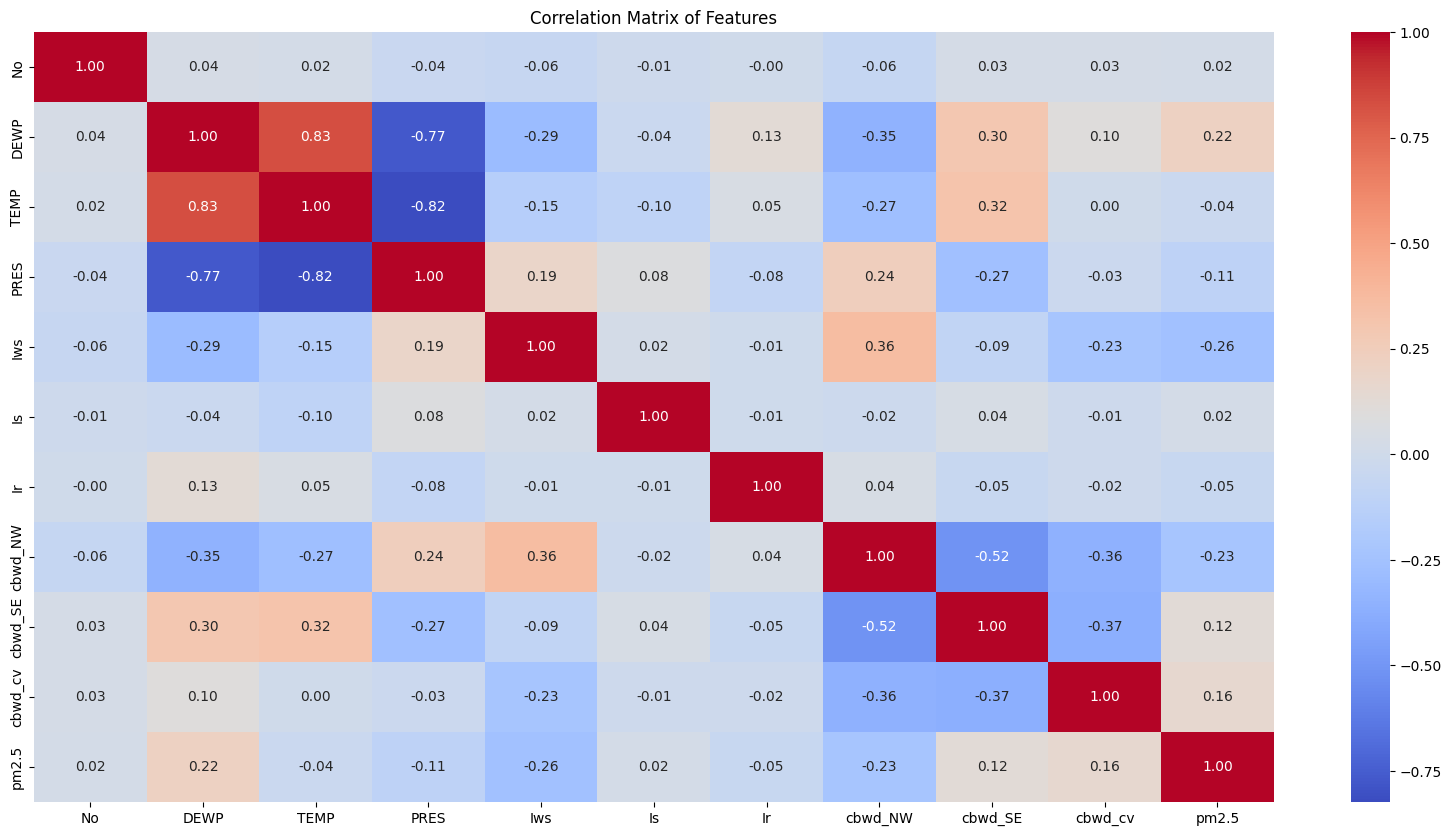

In [53]:
# Calculate correlations
# Remove non-numeric columns
import seaborn as sns
import pandas as pd

plt.figure(figsize=(20, 10))
correlation_matrix = train.select_dtypes(include=['number']).corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix of Features')
plt.show()

**Interpretation of the Result**

The strong negative correlation between DEWP and TEMP is expected, as dew point and temperature are inversely related in many climates.

The weak correlations with pm2.5 suggest that other factors (not included in this matrix) might be more influential in determining PM2.5 levels, such as traffic, industrial activity, or geographic location.

**3. Box Plot of Features to Identify Outliers**

The box plot visualize the distribution of data for different features and identify potential outliers.
Outliers are data points that fall significantly outside the typical range of values.

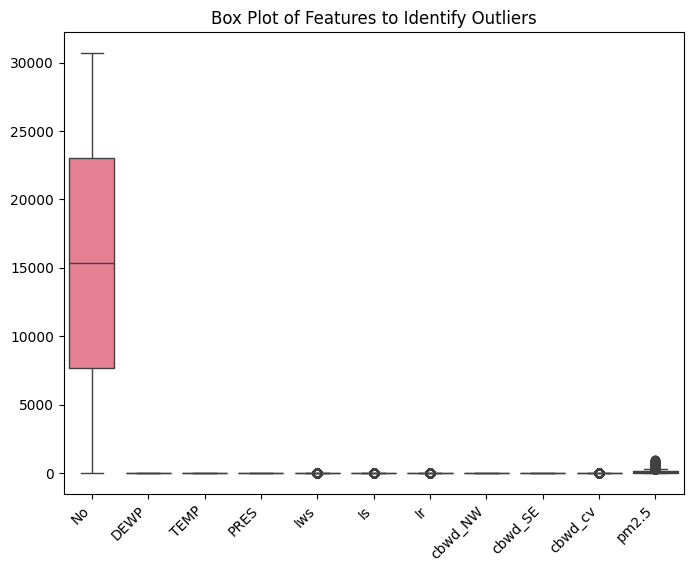

In [54]:
# Looking for outliers
plt.figure(figsize=(8, 6))
sns.boxplot(data=train)
plt.title('Box Plot of Features to Identify Outliers')
plt.xticks(rotation=45, ha='right')
plt.show()

**Interpretation of the Result**

If outliers are present, they could indicate errors in data collection, extreme events, or unique cases that deviate from the norm.

For example, if pm2.5 has outliers with extremely high values, it could indicate days with severe air pollution due to specific events.

Identifying outliers is important because they can skew analysis and modeling results, and may need to be addressed (e.g., removed or transformed).

In [55]:
# Checking for missing values
print("\nMissing values in training data:")
print(train.isnull().sum())


Missing values in training data:
No             0
DEWP           0
TEMP           0
PRES           0
Iws            0
Is             0
Ir             0
datetime       0
cbwd_NW        0
cbwd_SE        0
cbwd_cv        0
pm2.5       1921
dtype: int64


In [56]:
train.columns

Index(['No', 'DEWP', 'TEMP', 'PRES', 'Iws', 'Is', 'Ir', 'datetime', 'cbwd_NW',
       'cbwd_SE', 'cbwd_cv', 'pm2.5'],
      dtype='object')

In [57]:
# 'Datetime' column in 'Datetime' format
train['datetime'] = pd.to_datetime(train['datetime'])
test['datetime'] = pd.to_datetime(test['datetime'])
# Set'datetime' column as the index for better time-series handling
train.set_index('datetime', inplace=True)
# val.set_index('datetime', inplace=True)
test.set_index('datetime', inplace=True)

# **Handle missing values**
- Check the dataset for missing values and decide how to handle them.
- In this example, missing values are filled with the mean. You can experiment with other strategies.

In [58]:
train.fillna(train.mean(), inplace=True)
test.fillna(test.mean(), inplace=True)

# **Separate features and target**
- Feel free to trop any non-essential columns like that you think might not contribute to modeling.

In [59]:
X_train = train.drop(['pm2.5', 'No'], axis=1)
y_train = train['pm2.5']

In [60]:
# Reshape data for LSTM input
# LSTM models require data in the shape (samples, timesteps, features).
# Here, the data is reshaped to add a "timesteps" dimension.
X_train = np.expand_dims(X_train, axis=1)

# **Build model**
Below is a simple LSTM model. Your task is to experiment with different parameters like, numbers of layers, units, activation functions, and optimizers, etc to get the best performing model. Experiment with other optimizers (e.g., SGD) or hyperparameters to improve performance.

In [61]:
# Define Adam
# Define LSTM model
# Experiment: L2 regularization, ReLU activation
# LSTM layer with L2 regularization
# Dropout layer for regularization

from tensorflow.keras.regularizers import l2
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import Adam # Import Adam optimizer
model_1 = Sequential()
model_1.add(LSTM(128, activation='relu', return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2]), kernel_regularizer=l2(0.01)))
model_1.add(Dropout(0.2))
model_1.add(LSTM(64, activation='relu', kernel_regularizer=l2(0.01)))
model_1.add(Dropout(0.2))
model_1.add(Dense(32, activation='relu', kernel_regularizer=l2(0.01)))
model_1.add(Dense(1))

#Compile the model
model_1.compile(optimizer=Adam(learning_rate=0.001), loss='mse',
                metrics=[lambda y, y_pred: tf.sqrt(tf.reduce_mean(tf.square(y - y_pred)))])

#Display model summary
model_1.summary()
history_1 = model_1.fit(X_train, y_train, epochs=10, batch_size=32)

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_22"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_24 (LSTM)                  │ (None, 1, 128)         │        70,656 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 1, 128)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_25 (LSTM)                  │ (None, 64)             │        49,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_24 (Dense)                │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_25 (Dense)                │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 122,177 (477.25 KB)

 Trainable params: 122,177 (477.25 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
959/959 ━━━━━━━━━━━━━━━━━━━━ 10s 6ms/step - lambda: 98.3483 - loss: 10646.2051
Epoch 2/10
959/959 ━━━━━━━━━━━━━━━━━━━━ 7s 7ms/step - lambda: 73.9592 - loss: 5847.3433
Epoch 3/10
959/959 ━━━━━━━━━━━━━━━━━━━━ 9s 6ms/step - lambda: 72.1330 - loss: 5484.5093
Epoch 4/10
959/959 ━━━━━━━━━━━━━━━━━━━━ 10s 6ms/step - lambda: 71.2533 - loss: 5385.8735
Epoch 5/10
959/959 ━━━━━━━━━━━━━━━━━━━━ 7s 7ms/step - lambda: 71.7968 - loss: 5461.9219
Epoch 6/10
959/959 ━━━━━━━━━━━━━━━━━━━━ 9s 6ms/step - lambda: 71.2588 - loss: 5341.9360
Epoch 7/10
959/959 ━━━━━━━━━━━━━━━━━━━━ 10s 6ms/step - lambda: 71.3053 - loss: 5357.4849
Epoch 8/10
959/959 ━━━━━━━━━━━━━━━━━━━━ 11s 7ms/step - lambda: 71.2529 - loss: 5373.9731
Epoch 9/10
959/959 ━━━━━━━━━━━━━━━━━━━━ 7s 8ms/step - lambda: 70.1913 - loss: 5220.5723
Epoch 10/10
959/959 ━━━━━━━━━━━━━━━━━━━━ 8s 6ms/step - lambda: 70.0525 - loss: 5212.2129


In [62]:
# define model
model = Sequential([
    LSTM(128, activation='relu', input_shape=(X_train.shape[1], X_train.shape[2])),
    Dense(1)
])

# define model
model = Sequential([
    LSTM(64, activation='relu', input_shape=(X_train.shape[1], X_train.shape[2])),
    Dense(1)
])

# Compile the model
model.compile(
    optimizer=Adam(learning_rate= 0.001),
    loss='mse',
    metrics=[lambda y, y_pred: tf.sqrt(tf.reduce_mean(tf.square(y - y_pred)))]  # RMSE metric
)

# define model
model = Sequential([
    LSTM(32, activation='relu', input_shape=(X_train.shape[1], X_train.shape[2])),
    Dense(1)
])

# define model
model = Sequential([
    LSTM(32, activation='relu', input_shape=(X_train.shape[1], X_train.shape[2])),
    Dense(1)
])

# Compile the model
model.compile(
    optimizer=Adam(learning_rate= 0.001),
    loss='mse',
    metrics=[lambda y, y_pred: tf.sqrt(tf.reduce_mean(tf.square(y - y_pred)))]  # RMSE metric
)

# Display the model architecture
model.summary()

# Display the model architecture
model.summary()
model.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_26"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_29 (LSTM)                  │ (None, 32)             │         5,376 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_29 (Dense)                │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 5,409 (21.13 KB)

 Trainable params: 5,409 (21.13 KB)

 Non-trainable params: 0 (0.00 B)

Model: "sequential_26"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_29 (LSTM)                  │ (None, 32)             │         5,376 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_29 (Dense)                │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 5,409 (21.13 KB)

 Trainable params: 5,409 (21.13 KB)

 Non-trainable params: 0 (0.00 B)

Model: "sequential_26"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_29 (LSTM)                  │ (None, 32)             │         5,376 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_29 (Dense)                │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 5,409 (21.13 KB)

 Trainable params: 5,409 (21.13 KB)

 Non-trainable params: 0 (0.00 B)

959/959 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step


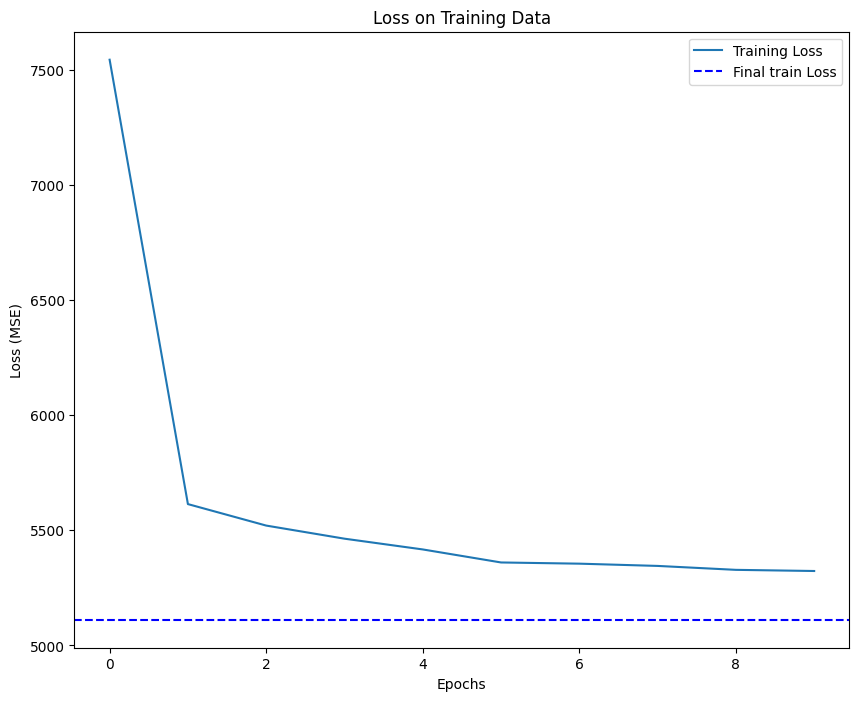

Final Training Loss (MSE): 5111.450403557835
Final Training Loss (RMSE): 71.49440819782926


In [63]:
# Calculate training loss
train_predictions = model_1.predict(X_train)
train_loss = np.mean((y_train - train_predictions.flatten())**2)
train_loss_RSME = np.sqrt(train_loss)

# Plot training loss
plt.figure(figsize=(10, 8))
plt.plot(history_1.history['loss'], label='Training Loss')
plt.axhline(y=train_loss, color='blue', linestyle='--', label='Final train Loss')
plt.title('Loss on Training Data')
plt.xlabel('Epochs')
plt.ylabel('Loss (MSE)')
plt.legend()
plt.show()

print(f"Final Training Loss (MSE): {train_loss}")
print(f"Final Training Loss (RMSE): {train_loss_RSME}")

In [64]:
# Prepare the test data
X_test = test.drop(['No'], axis=1)
X_test = np.expand_dims(X_test, axis=1)

# Make predictions on the test set using trained model to predict "pm2.5" concentrations
# Change 'model' to 'model_1' to match the name of the trained model
predictions = model_1.predict(X_test)

# Ensure predictions do not contain NaN values
predictions = np.nan_to_num(predictions)

# Convert predictions to integers
predictions = np.round(predictions).astype(int)

# Prepare submission file
# Convert 'row ID' index to string, remove leading zeros for single-digit hours
submission = pd.DataFrame({
    'row ID': pd.to_datetime(test.index).strftime('%Y-%m-%d %-H:%M:%S'),
    'pm2.5': predictions.flatten()
})

# Sort the submission by 'row ID' to match the solution file exactly
submission = submission.sort_values(by='row ID')



411/411 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


In [65]:
import os
from tensorflow.keras.models import save_model

# Define the path in your Google Drive where you want to save the model
# It's good practice to create a specific folder for your project/models
# Add the recommended .keras extension to the filepath
model_save_path = '/content/drive/MyDrive/Kaggle_competition_ML/air_quality_forcasting/my_lstm_model.keras' # or .keras for TensorFlow 2.x

# Create the directory if it doesn't exist
os.makedirs(os.path.dirname(model_save_path), exist_ok=True)

# Save the model
# Make sure you are saving the correct model. Based on your previous cells,
# you defined and compiled multiple models named 'model' and one named 'model_1'.
# The training history 'history_1' was associated with 'model_1'.
# If you intended to train 'model_1', you should save 'model_1'.
# However, your last 'model.summary()' calls and the error occur after defining
# multiple 'model' variables and then saving 'model'.
# This suggests the 'model' being saved might be the last one defined (a simple LSTM with 32 units),
# not necessarily the one trained ('model_1') with regularization and multiple layers.
# Double-check which model you intend to save.
# Assuming you want to save the last defined 'model' from cell 39:
model.save(model_save_path)
print(f"Model saved to: {model_save_path}")

# If you intended to save 'model_1' from cell 38, change the save call to:
# model_1.save(model_save_path)
# print(f"Model_1 saved to: {model_save_path}")

Model saved to: /content/drive/MyDrive/Kaggle_competition_ML/air_quality_forcasting/my_lstm_model.keras


/usr/local/lib/python3.11/dist-packages/keras/src/saving/serialization_lib.py:145: UserWarning: The object being serialized includes a `lambda`. This is unsafe. In order to reload the object, you will have to pass `safe_mode=False` to the loading function. Please avoid using `lambda` in the future, and use named Python functions instead. This is the `lambda` being serialized:     metrics=[lambda y, y_pred: tf.sqrt(tf.reduce_mean(tf.square(y - y_pred)))]  # RMSE metric

  config_arr = [serialize_keras_object(x) for x in obj]
